# Northern Ireland Monthly Deaths Analysis

There appears to be a persistent issue with raised mortality rates in Northern Ireland post the 2020 and 2020 pandemic years.

The purpose of this notebook is to investigate this phenomenon to try and determine root cause.

# Usage
Navigate to any section starting with *Configure:* and set the variables as needed for your notebook execution.

For example, the month for which the current year's data ends should be configured to support year-on-year comparison with complete data.

# Setup
We install our baseline Python dependencies as part of the Container build process.

We import our utility functions from our local library.

In [1]:
from lib.utility_functions import local_ca_certificate_file_path, debug_this, Month, download_file
import pandas as pd

## Configure: Subset of Months
Let's setup an ENUM to allow us to reference specific months.
This will be useful for the current years' dataset for which don't have all monthly data.

In [2]:
analysis_end_month = Month.AUGUST
analysis_end_month_for_deaths = analysis_end_month

## Configure: Debugging
Below is a global variable (bad!) that you can set to turn out debug statements. 
This will print intermediate dataframe and series data structures to aid troubleshooting.
It is disabled by default.

In [3]:
debug_enabled = True

# Prepare Monthly Deaths Data

## Acquire

Let's download the monthly deaths dataset from NISRA which is published here: https://www.nisra.gov.uk/publications/monthly-deaths.

This dataset provides the total number of monthly deaths by year from 2006 to the present.

In [4]:
raw_nisra_monthly_deaths_source_url='https://www.nisra.gov.uk/sites/nisra.gov.uk/files/publications/Monthly%20deaths.xlsx'
raw_nisra_monthly_deaths_dest_filepath='data/inbound/raw/nisra/deaths/monthly/monthly_deaths.xlsx'

download_file(raw_nisra_monthly_deaths_source_url, raw_nisra_monthly_deaths_dest_filepath)

downloaded from: https://www.nisra.gov.uk/sites/nisra.gov.uk/files/publications/Monthly%20deaths.xlsx


Let's load into a dataframe and proceed.

In [5]:
df_monthly_deaths = pd.read_excel(raw_nisra_monthly_deaths_dest_filepath,  
                                  sheet_name='Deaths', 
                                  skiprows=2, 
                                  nrows=12,
                                  usecols='A:R')

## Tidy Up

Let's rename the columns to be more user-friendly.

In [6]:
df_monthly_deaths_new_column_names = df_monthly_deaths.rename(columns={"2021\n[Note 1]":"2021", "2022\n[Note 1]":"2022", "Month of \nRegistration":"Registration_Month"})

Let's replace all NaN values with zeros for now.

In [7]:
df_monthly_deaths_nans_removed = df_monthly_deaths_new_column_names.fillna(0)

Let's apply types to our columns - nothing more than basic string and integers.

In [8]:
df_monthly_deaths_typed = df_monthly_deaths_nans_removed.astype({'Registration_Month': str, '2006': int, '2007': int, '2008': int, '2009': int, '2010': int, '2011': int, '2012': int, '2013': int, '2014': int, '2015': int, '2016': int, '2017': int, '2018': int, '2019': int, '2020': int, '2021': int, '2022': int})

debug_this(debug_enabled, df_monthly_deaths_typed)

   Registration_Month  2006  2007  2008  2009  2010  2011  2012  2013  2014  \
0             January  1367  1551  1579  1677  1445  1538  1433  1535  1523   
1            February  1180  1333  1252  1248  1242  1176  1267  1310  1192   
2               March  1475  1304  1314  1252  1427  1305  1316  1370  1294   
3               April  1179  1270  1318  1160  1165  1096  1281  1448  1219   
4                 May  1238  1214  1115  1075  1012  1223  1329  1239  1095   
5                June  1202  1128  1166  1207  1163  1164  1110  1045  1042   
6                July  1148  1132  1195  1112  1057   985  1132  1224  1151   
7              August  1145  1144  1021   975  1111  1203  1167  1079  1109   
8           September  1134   977  1203  1148  1111  1076  1050  1159  1284   
9             October  1230  1277  1196  1155  1150  1128  1259  1217  1308   
10           November  1187  1205  1129  1158  1288  1134  1235  1185  1155   
11           December  1047  1114  1419  1246  1286 

# Prepare Population Data
We will want to adjust these death figures based on population as the population in NI has been (and should continue) to increase.

We can look to this document for mid-year estimates of population in Northern Ireland - https://www.nisra.gov.uk/sites/nisra.gov.uk/files/publications/MYE20-POP-TOTAL.xlsx

This is largely a hack but should still improve accuracy as using absolute number without considering the change in the population is problematic.

Using the mid-year figure is likely to be more accurate than an end-of-year figure.


## Acquire
Let's read the estimates for Northern Ireland from 1971 until 2020 inclusive.

In [9]:
raw_nisra_mid_year_population_estimates_source_url='https://www.nisra.gov.uk/sites/nisra.gov.uk/files/publications/MYE20-POP-TOTAL.xlsx'
raw_nisra_mid_year_population_estimates_dest_filepath='data/inbound/raw/nisra/population/mye_population_total.xlsx'

download_file(raw_nisra_mid_year_population_estimates_source_url, raw_nisra_mid_year_population_estimates_dest_filepath)

downloaded from: https://www.nisra.gov.uk/sites/nisra.gov.uk/files/publications/MYE20-POP-TOTAL.xlsx


In [10]:

df_population_estimate = pd.read_excel(raw_nisra_mid_year_population_estimates_dest_filepath, 
                                  sheet_name='Flat', 
                                  skiprows=0, 
                                  nrows=100,
                                  usecols='A:F')

Let's include only the rounded figures for simplicity.

In [11]:
df_rounded_population_estimates = df_population_estimate[df_population_estimate['type'] == 'Rounded']
df_rounded_population_estimates.count()

area         50
area_code    50
area_name    50
year         50
type         50
MYE          50
dtype: int64

Let's include only the years in our mortality dataset - 2006 onwards.

## Subset & Profile
We're only interested in data from 2006 onwards.

In [12]:
df_population_estimate_2006_to_2020 = \
    df_rounded_population_estimates[df_rounded_population_estimates['year'] >= 2006]

df_year_and_mye_only = df_population_estimate_2006_to_2020[['year','MYE']]

Let's plot the mid-year population estimates over this 15 year period.

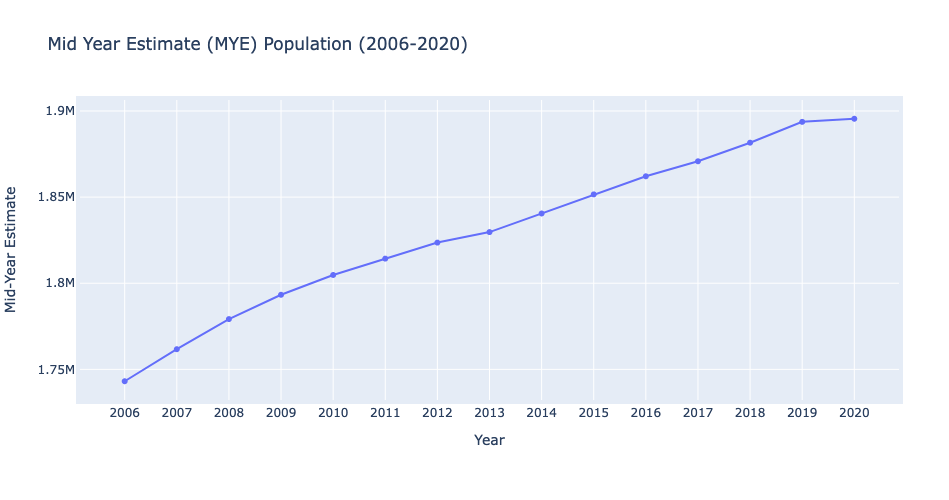

In [13]:
import plotly.offline as pyo
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# pyo.init_notebook_mode()

# Create figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": False}]])


fig.add_trace(
    go.Scatter(x=df_year_and_mye_only['year'], y=df_year_and_mye_only['MYE'], name="Mid Year Estimate (MYE) Population (2006-2020)"),
    secondary_y=False,
)

fig.update_layout(
    height=500,
    margin=dict(
        l=50,
        r=50,
        b=100,
        t=100,
        pad=4
    )
)


# Add figure title
fig.update_layout(
    title_text="Mid Year Estimate (MYE) Population (2006-2020)"
)

# Set x-axis title
fig.update_xaxes(title_text="Year", type='category')

# Set y-axes titles
fig.update_yaxes(title_text="Mid-Year Estimate", secondary_y=False)

fig.show()

## Impute 2020 and 20201 Population Figures
We're only interested in data from 2006 onwards.

We don't have figures for 2020 nor 2021 at this point.

However, perhaps we can impute them.

Can we use Linear Regression to crudely estimate what the MYE for population will be for 2021 and 2022?

Let's take a gander again at our population dataframe

In [14]:
import numpy as np
from sklearn.linear_model import LinearRegression 


debug_this(debug_enabled, 'Number of dimensions in population dataframe: ' + str(df_population_estimate_2006_to_2020.ndim))
debug_this(debug_enabled, 'Shape of population dataframe: ' + str(df_population_estimate_2006_to_2020.shape))
debug_this(debug_enabled, 'Size of population dataframe: ' + str(df_population_estimate_2006_to_2020.size))

Number of dimensions in population dataframe: 2
Shape of population dataframe: (15, 6)
Size of population dataframe: 90


Let's use the year column as a predictor (for what it's worth) and the population as the outcome variable.

We will need to wrangle the data to meet the needs of the Linear Regression API.

We do this by supplying two 2-dimensional arrays of predictor variables and outcome variables.  We convert from Pandas dataframe to numpy array and then reshape the array as required.


In [15]:
series_year = df_population_estimate_2006_to_2020['year']

array_year = series_year.to_numpy()
array_year_reshaped = array_year.reshape(-1, 1)

df_year = df_population_estimate_2006_to_2020[['year']]


series_population = df_population_estimate_2006_to_2020['MYE']

array_population = series_population.to_numpy()
array_population_reshaped = array_population.reshape(-1, 1)

We can now train the model

In [16]:
lm = LinearRegression()
model = lm.fit(array_year_reshaped, array_population_reshaped)

And predict 2020 and 2021 values using the trained model

In [17]:
mye_prediction_2021 = int(model.predict(np.array([2021]).reshape(1,-1))[0][0])

debug_this(debug_enabled, '2021 estimate: ' + str(mye_prediction_2021))

mye_prediction_2022 = int(model.predict(np.array([2022]).reshape(1,-1))[0][0])

debug_this(debug_enabled, '2022 estimate: ' + str(mye_prediction_2022))


2021 estimate: 1913820
2022 estimate: 1924335


We can now add these values to our source data as imputed items.

In [18]:
df_imputed_myes = pd.DataFrame([[2021, mye_prediction_2021],[2022, mye_prediction_2022]], columns=['year','MYE'])

df_mye_2006_to_2022 = pd.concat([df_year_and_mye_only,df_imputed_myes], axis=0)

debug_this(debug_enabled, df_mye_2006_to_2022)

    year      MYE
70  2006  1743100
72  2007  1761700
74  2008  1779200
76  2009  1793300
78  2010  1804800
80  2011  1814300
82  2012  1823600
84  2013  1829700
86  2014  1840500
88  2015  1851600
90  2016  1862100
92  2017  1870800
94  2018  1881600
96  2019  1893700
98  2020  1895500
0   2021  1913820
1   2022  1924335


Let's plot these points by updating the graph we plotted above.

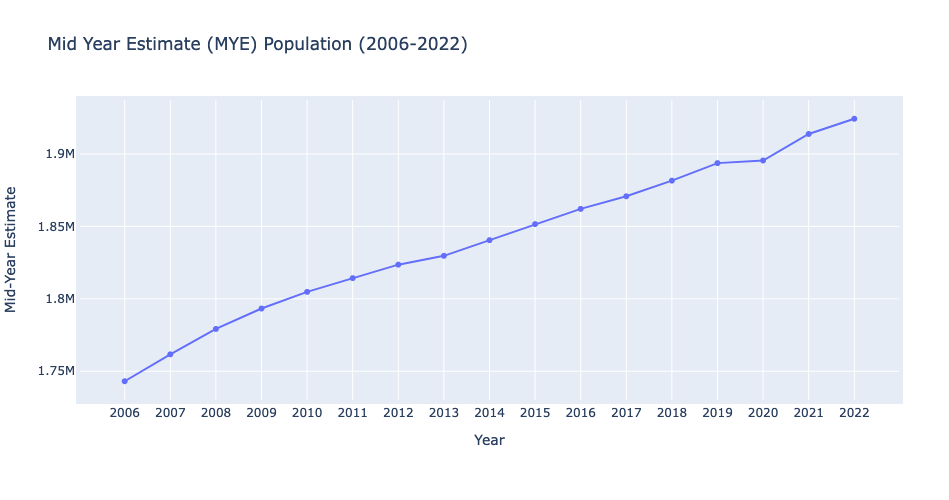

In [19]:
import plotly.offline as pyo
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# pyo.init_notebook_mode()

# Create figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": False}]])


fig.add_trace(
    go.Scatter(x=df_mye_2006_to_2022['year'], y=df_mye_2006_to_2022['MYE'], name="Mid Year Estimate (MYE) Population (2006-2020)"),
    secondary_y=False,
)

fig.update_layout(
    height=500,
    margin=dict(
        l=50,
        r=50,
        b=100,
        t=100,
        pad=4
    )
)


# Add figure title
fig.update_layout(
    title_text="Mid Year Estimate (MYE) Population (2006-2022)"
)

# Set x-axis title
fig.update_xaxes(title_text="Year", type='category')

# Set y-axes titles
fig.update_yaxes(title_text="Mid-Year Estimate", secondary_y=False)

fig.show()

Looking at the projected line for 2021 and 2022, my reading is that this is possibly a generous estimate.

I suspect the actual population figures will be lower than this.

I base this suspicion on the reduced travel, sickness, disruption to the economy and normal ways of life that has occurred and continues to occur since March 2020.

# Analyse Monthly Deaths Data

## Total Monthly Deaths 2006-2022

Let's calculate the total deaths (unadjusted for population growth) for each year.

We know 2022 is going to be anomalous throughout this exercise as at the time of writing we have only 5 months of data, but we persevere.

In [20]:
# Calculate the sums along the column values for all 12 months.
series_twelve_month_total = df_monthly_deaths_typed[['Registration_Month','2006','2007','2008','2009','2010','2011','2012','2013','2014','2015','2016','2017','2018','2019','2020','2021']].sum(axis=0, numeric_only=True)

df_twelve_month_total = pd.DataFrame(series_twelve_month_total).reset_index().rename(columns = {'index':'year', 0:'deaths'})

debug_this(debug_enabled, df_twelve_month_total)

    year  deaths
0   2006   14532
1   2007   14649
2   2008   14907
3   2009   14413
4   2010   14457
5   2011   14204
6   2012   14756
7   2013   14968
8   2014   14678
9   2015   15548
10  2016   15430
11  2017   16036
12  2018   15922
13  2019   15758
14  2020   17614
15  2021   17556


Let's plot these figures to have a look at the trend.

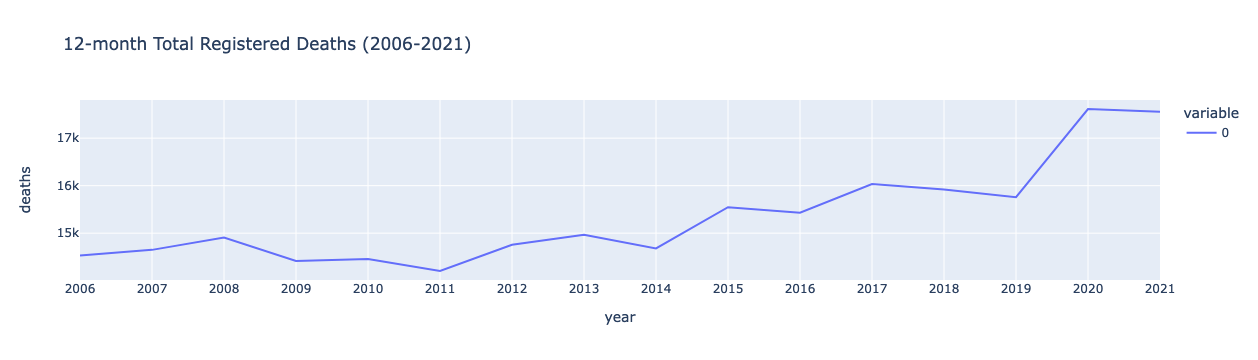

In [21]:
pd.options.plotting.backend = "plotly"

twelve_month_fig = series_twelve_month_total.plot(title='12-month Total Registered Deaths (2006-2021)', labels=dict(index='year', value='deaths'))
twelve_month_fig.show()

In [22]:
import plotly.graph_objects as go
import plotly.express as px

In [23]:
debug_this(debug_enabled, df_monthly_deaths_typed.describe())
debug_this(debug_enabled, df_monthly_deaths_typed.shape)
debug_this(debug_enabled, df_monthly_deaths_typed)

              2006         2007       2008         2009         2010  \
count    12.000000    12.000000    12.0000    12.000000    12.000000   
mean   1211.000000  1220.750000  1242.2500  1201.083333  1204.750000   
std     112.376801   143.861755   149.3374   169.698909   136.487179   
min    1047.000000   977.000000  1021.0000   975.000000  1012.000000   
25%    1147.250000  1131.000000  1156.7500  1139.000000  1111.000000   
50%    1183.500000  1209.500000  1199.5000  1159.000000  1164.000000   
75%    1232.000000  1283.750000  1315.0000  1246.500000  1286.500000   
max    1475.000000  1551.000000  1579.0000  1677.000000  1445.000000   

              2011         2012         2013         2014         2015  \
count    12.000000    12.000000    12.000000    12.000000    12.000000   
mean   1183.666667  1229.666667  1247.333333  1223.166667  1295.666667   
std     137.182913   107.205269   145.430604   129.965613   155.943074   
min     985.000000  1050.000000  1045.000000  1042.0000

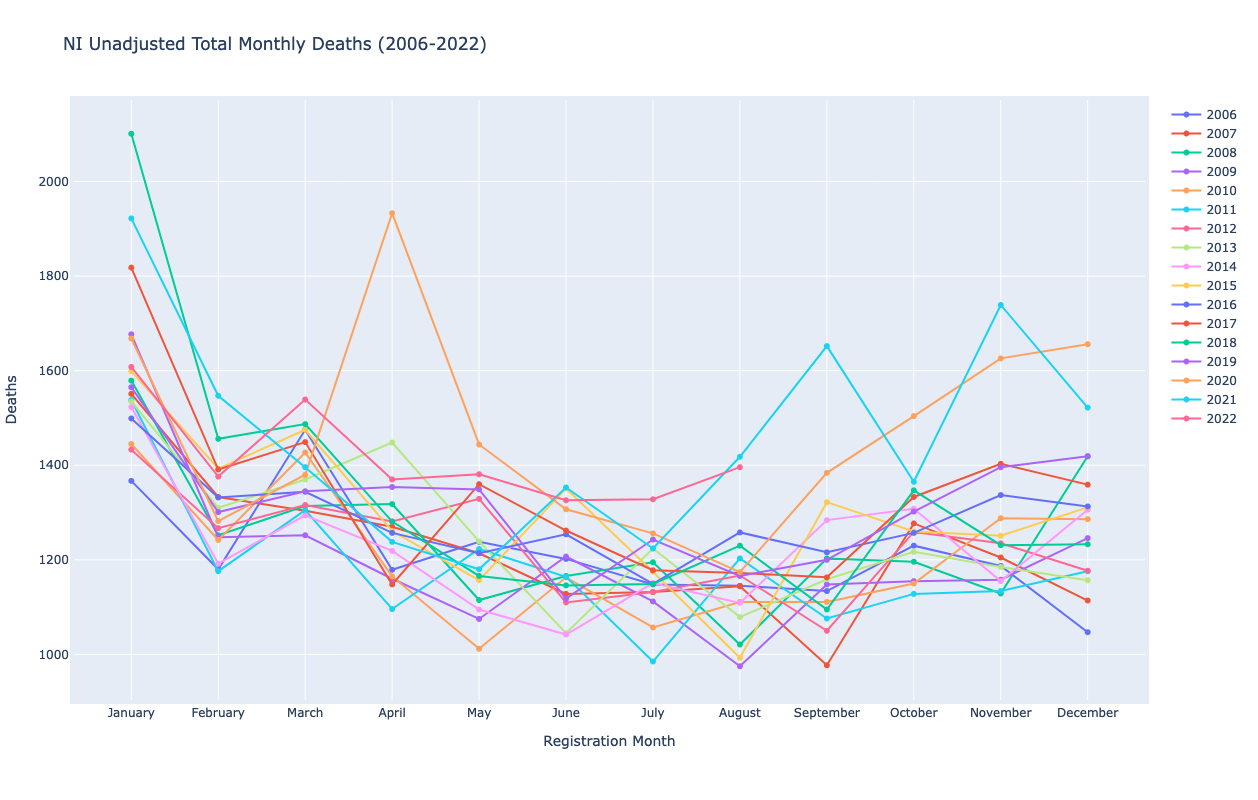

In [24]:
import plotly.offline as pyo
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# pyo.init_notebook_mode()

# Create figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": False}]])


fig.add_trace(
    go.Scatter(x=df_monthly_deaths_typed['Registration_Month'], y=df_monthly_deaths_typed['2006'], name="2006"),
    secondary_y=False,
)

fig.add_trace(
    go.Scatter(x=df_monthly_deaths_typed['Registration_Month'], y=df_monthly_deaths_typed['2007'], name="2007"),
    secondary_y=False,
)

fig.add_trace(
    go.Scatter(x=df_monthly_deaths_typed['Registration_Month'], y=df_monthly_deaths_typed['2008'], name="2008"),
    secondary_y=False,
)

fig.add_trace(
    go.Scatter(x=df_monthly_deaths_typed['Registration_Month'], y=df_monthly_deaths_typed['2009'], name="2009"),
    secondary_y=False,
)


fig.add_trace(
    go.Scatter(x=df_monthly_deaths_typed['Registration_Month'], y=df_monthly_deaths_typed['2010'], name="2010"),
    secondary_y=False,
)


fig.add_trace(
    go.Scatter(x=df_monthly_deaths_typed['Registration_Month'], y=df_monthly_deaths_typed['2011'], name="2011"),
    secondary_y=False,
)


fig.add_trace(
    go.Scatter(x=df_monthly_deaths_typed['Registration_Month'], y=df_monthly_deaths_typed['2012'], name="2012"),
    secondary_y=False,
)

fig.add_trace(
    go.Scatter(x=df_monthly_deaths_typed['Registration_Month'], y=df_monthly_deaths_typed['2013'], name="2013"),
    secondary_y=False,
)

fig.add_trace(
    go.Scatter(x=df_monthly_deaths_typed['Registration_Month'], y=df_monthly_deaths_typed['2014'], name="2014"),
    secondary_y=False,
)



fig.add_trace(
    go.Scatter(x=df_monthly_deaths_typed['Registration_Month'], y=df_monthly_deaths_typed['2015'], name="2015"),
    secondary_y=False,
)


fig.add_trace(
    go.Scatter(x=df_monthly_deaths_typed['Registration_Month'], y=df_monthly_deaths_typed['2016'], name="2016"),
    secondary_y=False,
)


fig.add_trace(
    go.Scatter(x=df_monthly_deaths_typed['Registration_Month'], y=df_monthly_deaths_typed['2017'], name="2017"),
    secondary_y=False,
)

fig.add_trace(
    go.Scatter(x=df_monthly_deaths_typed['Registration_Month'], y=df_monthly_deaths_typed['2018'], name="2018"),
    secondary_y=False,
)


fig.add_trace(
    go.Scatter(x=df_monthly_deaths_typed['Registration_Month'], y=df_monthly_deaths_typed['2019'], name="2019"),
    secondary_y=False,
)


fig.add_trace(
    go.Scatter(x=df_monthly_deaths_typed['Registration_Month'], y=df_monthly_deaths_typed['2020'], name="2020"),
    secondary_y=False,
)


fig.add_trace(
    go.Scatter(x=df_monthly_deaths_typed['Registration_Month'], y=df_monthly_deaths_typed['2021'], name="2021"),
    secondary_y=False,
)


fig.add_trace(
    go.Scatter(x=df_monthly_deaths_typed['Registration_Month'], y=df_monthly_deaths_typed['2022'].loc[0:(analysis_end_month_for_deaths -1)], name="2022"),
    secondary_y=False,
)

fig.update_layout(
    height=800,
    margin=dict(
        l=50,
        r=50,
        b=100,
        t=100,
        pad=4
    )
)


# Add figure title
fig.update_layout(
    title_text="NI Unadjusted Total Monthly Deaths (2006-2022)"
)

# Set x-axis title
fig.update_xaxes(title_text="Registration Month", type='category')

# Set y-axes titles
fig.update_yaxes(title_text="Deaths", secondary_y=False)

fig.show()

## Total Monthly Deaths 2006-2021 for Configured Subset of Months Only

Let's also calculate the total deaths for a range of months in the year.

We'll do this through a variable that allows us to specify the range of months we want to include in our analysis.

This is useful because for 2022 we only have (provisional) data for part of the year only.

Set this variable to an enum month value - but ensure you have sufficient Deaths data for each month in question.


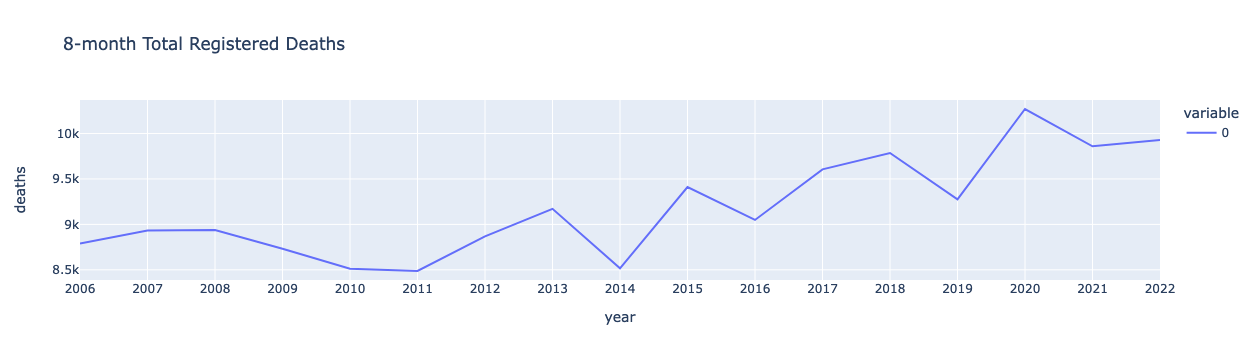

In [25]:
analysis_end_month_index = analysis_end_month - 1

series_range_month_total = df_monthly_deaths_typed[['Registration_Month','2006','2007','2008','2009','2010','2011','2012','2013','2014','2015','2016','2017','2018','2019','2020','2021', '2022']][0:analysis_end_month_index].sum(axis=0, numeric_only=True)

title = str(analysis_end_month.value) + '-month Total Registered Deaths'
range_month_fig = series_range_month_total.plot(title=title, labels=dict(index='year', value='deaths'))
range_month_fig.show()

df_range_month_total = pd.DataFrame(series_range_month_total).reset_index().rename(columns = {'index':'year', 0:'deaths'})

## Monthly Deaths Z-Score for 2015-2022 against 2015-2019 Average

Let's work off a baseline five-year average figure for monthly deaths.  

We will use the 2015-2019 mean total deaths figure to compare against 2020, 2021 and 2022.

We do this as this is the most recent average we can compute outside of the anomalous "Pandemic Period" (>=2020).

Let's add in the 2015-2019 five-year mean figure to our dataset.

In [26]:
normal_five_year_range=['2015','2016','2017','2018','2019']

df_monthly_deaths_typed['2015_to_2019_Mean'] = df_monthly_deaths_typed[normal_five_year_range].mean(axis=1)

debug_this(debug_enabled, df_monthly_deaths_typed)

   Registration_Month  2006  2007  2008  2009  2010  2011  2012  2013  2014  \
0             January  1367  1551  1579  1677  1445  1538  1433  1535  1523   
1            February  1180  1333  1252  1248  1242  1176  1267  1310  1192   
2               March  1475  1304  1314  1252  1427  1305  1316  1370  1294   
3               April  1179  1270  1318  1160  1165  1096  1281  1448  1219   
4                 May  1238  1214  1115  1075  1012  1223  1329  1239  1095   
5                June  1202  1128  1166  1207  1163  1164  1110  1045  1042   
6                July  1148  1132  1195  1112  1057   985  1132  1224  1151   
7              August  1145  1144  1021   975  1111  1203  1167  1079  1109   
8           September  1134   977  1203  1148  1111  1076  1050  1159  1284   
9             October  1230  1277  1196  1155  1150  1128  1259  1217  1308   
10           November  1187  1205  1129  1158  1288  1134  1235  1185  1155   
11           December  1047  1114  1419  1246  1286 

Let's calculate and add in Standard Deviation (SD) for the 2015-2019 five-year period also.

In [27]:
df_monthly_deaths_typed['2015_to_2019_SD'] = df_monthly_deaths_typed[normal_five_year_range].std(axis=1)

debug_this(debug_enabled, df_monthly_deaths_typed)

   Registration_Month  2006  2007  2008  2009  2010  2011  2012  2013  2014  \
0             January  1367  1551  1579  1677  1445  1538  1433  1535  1523   
1            February  1180  1333  1252  1248  1242  1176  1267  1310  1192   
2               March  1475  1304  1314  1252  1427  1305  1316  1370  1294   
3               April  1179  1270  1318  1160  1165  1096  1281  1448  1219   
4                 May  1238  1214  1115  1075  1012  1223  1329  1239  1095   
5                June  1202  1128  1166  1207  1163  1164  1110  1045  1042   
6                July  1148  1132  1195  1112  1057   985  1132  1224  1151   
7              August  1145  1144  1021   975  1111  1203  1167  1079  1109   
8           September  1134   977  1203  1148  1111  1076  1050  1159  1284   
9             October  1230  1277  1196  1155  1150  1128  1259  1217  1308   
10           November  1187  1205  1129  1158  1288  1134  1235  1185  1155   
11           December  1047  1114  1419  1246  1286 

And let's now use the mean and SD for 2015-2019 period to calculate the z-score for all years in the range and the "Pandemic Period" years 2020-2022.

We will calculate the z-score using: ${z} = (x-\mu)/\sigma $

In [28]:
df_monthly_deaths_typed['2015_zscore_for_2015_to_2019'] = ((df_monthly_deaths_typed['2015'] - df_monthly_deaths_typed['2015_to_2019_Mean'])/df_monthly_deaths_typed['2015_to_2019_SD'])
df_monthly_deaths_typed['2016_zscore_for_2015_to_2019'] = ((df_monthly_deaths_typed['2016'] - df_monthly_deaths_typed['2015_to_2019_Mean'])/df_monthly_deaths_typed['2015_to_2019_SD'])
df_monthly_deaths_typed['2017_zscore_for_2015_to_2019'] = ((df_monthly_deaths_typed['2017'] - df_monthly_deaths_typed['2015_to_2019_Mean'])/df_monthly_deaths_typed['2015_to_2019_SD'])
df_monthly_deaths_typed['2018_zscore_for_2015_to_2019'] = ((df_monthly_deaths_typed['2018'] - df_monthly_deaths_typed['2015_to_2019_Mean'])/df_monthly_deaths_typed['2015_to_2019_SD'])
df_monthly_deaths_typed['2019_zscore_for_2015_to_2019'] = ((df_monthly_deaths_typed['2019'] - df_monthly_deaths_typed['2015_to_2019_Mean'])/df_monthly_deaths_typed['2015_to_2019_SD'])
df_monthly_deaths_typed['2020_zscore_for_2015_to_2019'] = ((df_monthly_deaths_typed['2020'] - df_monthly_deaths_typed['2015_to_2019_Mean'])/df_monthly_deaths_typed['2015_to_2019_SD'])
df_monthly_deaths_typed['2021_zscore_for_2015_to_2019'] = ((df_monthly_deaths_typed['2021'] - df_monthly_deaths_typed['2015_to_2019_Mean'])/df_monthly_deaths_typed['2015_to_2019_SD'])
df_monthly_deaths_typed['2022_zscore_for_2015_to_2019'] = ((df_monthly_deaths_typed['2022'] - df_monthly_deaths_typed['2015_to_2019_Mean'])/df_monthly_deaths_typed['2015_to_2019_SD'])

debug_this(debug_enabled, df_monthly_deaths_typed)

   Registration_Month  2006  2007  2008  2009  2010  2011  2012  2013  2014  \
0             January  1367  1551  1579  1677  1445  1538  1433  1535  1523   
1            February  1180  1333  1252  1248  1242  1176  1267  1310  1192   
2               March  1475  1304  1314  1252  1427  1305  1316  1370  1294   
3               April  1179  1270  1318  1160  1165  1096  1281  1448  1219   
4                 May  1238  1214  1115  1075  1012  1223  1329  1239  1095   
5                June  1202  1128  1166  1207  1163  1164  1110  1045  1042   
6                July  1148  1132  1195  1112  1057   985  1132  1224  1151   
7              August  1145  1144  1021   975  1111  1203  1167  1079  1109   
8           September  1134   977  1203  1148  1111  1076  1050  1159  1284   
9             October  1230  1277  1196  1155  1150  1128  1259  1217  1308   
10           November  1187  1205  1129  1158  1288  1134  1235  1185  1155   
11           December  1047  1114  1419  1246  1286 

Now let's plot the Z-scores for 2020, 2021 and 2022 and highlight those that exhibit statistically significant changes from the 2015-2019 mean.

We will use $ \mu \pm 2\sigma $ as the bar for statistical significance.


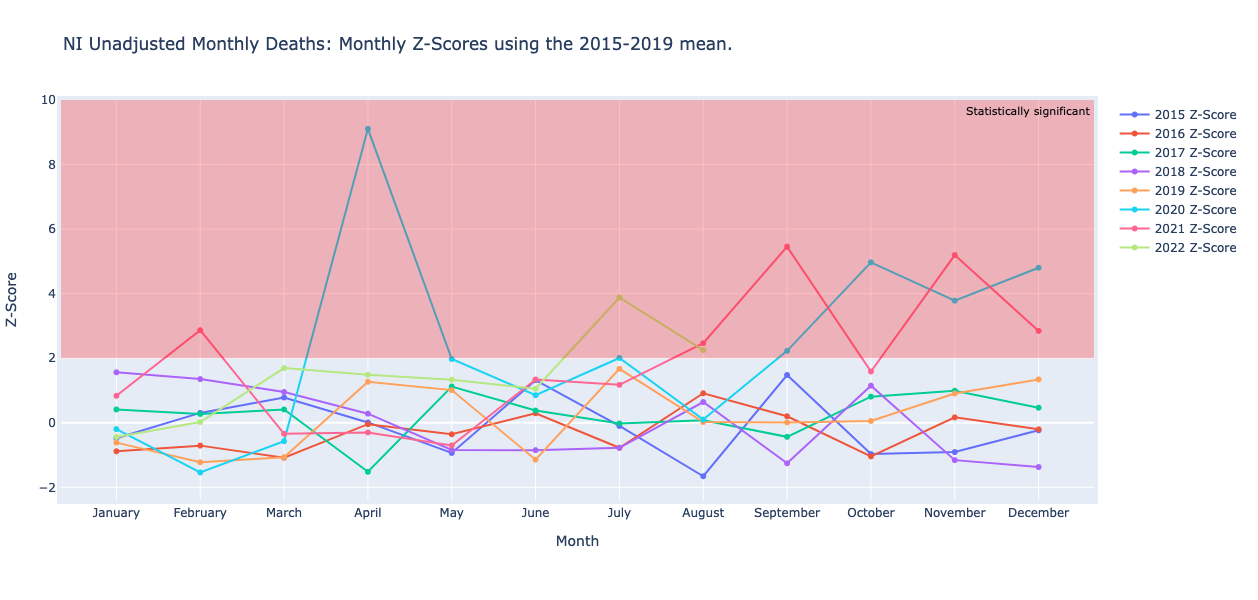

In [29]:
import plotly.offline as pyo
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# pyo.init_notebook_mode()

# Create figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": False}]])


fig.add_trace(
    go.Scatter(x=df_monthly_deaths_typed['Registration_Month'], y=df_monthly_deaths_typed['2015_zscore_for_2015_to_2019'], name="2015 Z-Score"),
    secondary_y=False,
)

fig.add_trace(
    go.Scatter(x=df_monthly_deaths_typed['Registration_Month'], y=df_monthly_deaths_typed['2016_zscore_for_2015_to_2019'], name="2016 Z-Score"),
    secondary_y=False,
)

fig.add_trace(
    go.Scatter(x=df_monthly_deaths_typed['Registration_Month'], y=df_monthly_deaths_typed['2017_zscore_for_2015_to_2019'], name="2017 Z-Score"),
    secondary_y=False,
)

fig.add_trace(
    go.Scatter(x=df_monthly_deaths_typed['Registration_Month'], y=df_monthly_deaths_typed['2018_zscore_for_2015_to_2019'], name="2018 Z-Score"),
    secondary_y=False,
)

fig.add_trace(
    go.Scatter(x=df_monthly_deaths_typed['Registration_Month'], y=df_monthly_deaths_typed['2019_zscore_for_2015_to_2019'], name="2019 Z-Score"),
    secondary_y=False,
)

fig.add_trace(
    go.Scatter(x=df_monthly_deaths_typed['Registration_Month'], y=df_monthly_deaths_typed['2020_zscore_for_2015_to_2019'], name="2020 Z-Score"),
    secondary_y=False,
)

fig.add_trace(
    go.Scatter(x=df_monthly_deaths_typed['Registration_Month'], y=df_monthly_deaths_typed['2021_zscore_for_2015_to_2019'], name="2021 Z-Score"),
    secondary_y=False,
)

fig.add_trace(
    go.Scatter(x=df_monthly_deaths_typed['Registration_Month'], y=df_monthly_deaths_typed['2022_zscore_for_2015_to_2019'].loc[0:(analysis_end_month_for_deaths - 1)], name="2022 Z-Score"),
    secondary_y=False,
)


fig.add_hrect(y0=2, y1=10, 
              annotation_text="Statistically significant", annotation_position="top right",  
              annotation_font_size=11,
              annotation_font_color="Black",
              fillcolor="red", opacity=0.25, line_width=0)

fig.update_layout(
    height=600,
    margin=dict(
        l=50,
        r=50,
        b=100,
        t=100,
        pad=4
    )
)

# Add figure title
fig.update_layout(
    title_text="NI Unadjusted Monthly Deaths: Monthly Z-Scores using the 2015-2019 mean."
)

# Set x-axis title
fig.update_xaxes(title_text="Month")

# Set y-axes titles
fig.update_yaxes(title_text="Z-Score", secondary_y=False)

fig.show()

## Population-Adjusted Monthly Deaths

Let's join the death and population datasets together and then calculate a population-adjusted figure for mortality for each month.

First, we must make sure the data types are the same in each dataframe. Otherwise we won't be able to join.

In [30]:
# Let's change the type of the year column in df_twelve_month_total_column_renamed before we merge.
df_twelve_month_total_typed = df_twelve_month_total.astype({'year': int})

df_deaths_and_myes_for_twelve_months = df_mye_2006_to_2022.merge(df_twelve_month_total_typed, how='inner', on='year') 

debug_this(debug_enabled, '\n Year and Total Deaths in 12 months of each year. \n')
debug_this(debug_enabled, df_deaths_and_myes_for_twelve_months)


 Year and Total Deaths in 12 months of each year. 

    year      MYE  deaths
0   2006  1743100   14532
1   2007  1761700   14649
2   2008  1779200   14907
3   2009  1793300   14413
4   2010  1804800   14457
5   2011  1814300   14204
6   2012  1823600   14756
7   2013  1829700   14968
8   2014  1840500   14678
9   2015  1851600   15548
10  2016  1862100   15430
11  2017  1870800   16036
12  2018  1881600   15922
13  2019  1893700   15758
14  2020  1895500   17614
15  2021  1913820   17556


Let's repeat the above but for our subset range of months foreach year.

In [31]:
df_range_month_total_typed = df_range_month_total.astype({'year': int})

df_deaths_and_myes_for_range_months = df_mye_2006_to_2022.merge(df_range_month_total_typed, how='inner', on='year') 

debug_this(debug_enabled, '\n Year and Total Deaths in first ' + str(analysis_end_month) + ' months of each year. \n')
debug_this(debug_enabled, df_deaths_and_myes_for_range_months)


 Year and Total Deaths in first Month.AUGUST months of each year. 

    year      MYE  deaths
0   2006  1743100    8789
1   2007  1761700    8932
2   2008  1779200    8939
3   2009  1793300    8731
4   2010  1804800    8511
5   2011  1814300    8487
6   2012  1823600    8868
7   2013  1829700    9171
8   2014  1840500    8516
9   2015  1851600    9411
10  2016  1862100    9049
11  2017  1870800    9606
12  2018  1881600    9786
13  2019  1893700    9275
14  2020  1895500   10270
15  2021  1913820    9860
16  2022  1924335    9928


df_deaths_and_myes_for_range_monthsUsing this composite dataset, let's impute the total number of deaths per 100k of the population for each of the 17 years' worth of data.

In [32]:
df_twelve_month_deaths_per_100k = df_deaths_and_myes_for_twelve_months[['year']].copy()

df_twelve_month_deaths_per_100k['deaths_per_100k'] = \
    (df_deaths_and_myes_for_twelve_months['deaths'] * 100000 / df_deaths_and_myes_for_twelve_months['MYE']).astype(int)

debug_this(debug_enabled, '\n Total Deaths per 100k of the population for 12 months in the year. \n')
debug_this(debug_enabled, df_twelve_month_deaths_per_100k)


 Total Deaths per 100k of the population for 12 months in the year. 

    year  deaths_per_100k
0   2006              833
1   2007              831
2   2008              837
3   2009              803
4   2010              801
5   2011              782
6   2012              809
7   2013              818
8   2014              797
9   2015              839
10  2016              828
11  2017              857
12  2018              846
13  2019              832
14  2020              929
15  2021              917


Now, let's plot the death rates per 100k in the population for the past 17 years.

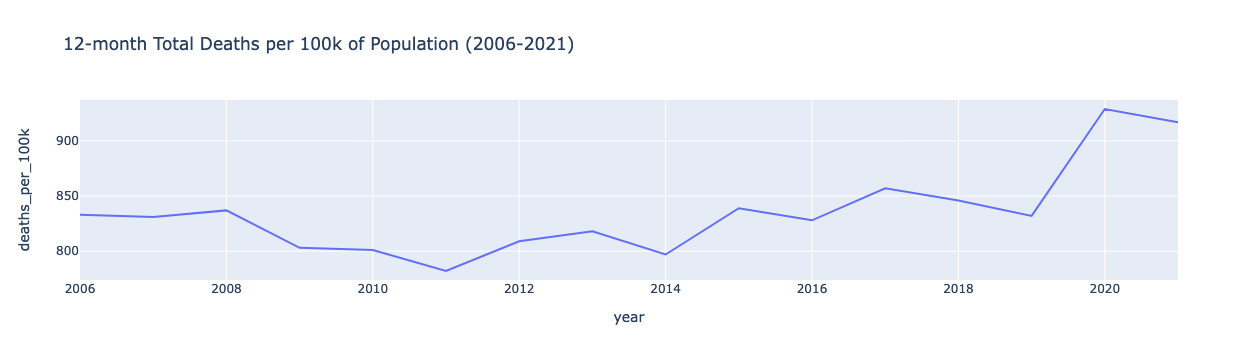

In [33]:
fig_twelve_month_deaths_per_100k_17_yrs = df_twelve_month_deaths_per_100k.plot.line(title='12-month Total Deaths per 100k of Population (2006-2021)',
                                                x='year', 
                                                y='deaths_per_100k')
fig_twelve_month_deaths_per_100k_17_yrs.show()

We can see that a sharp uplift occurred in 2020 and that has not normalised back to the expected level (ignoring the 2022 incomplete figures).

We can repeat the same plot for our subset/range of months in the year.

In [34]:
df_range_months_deaths_per_100k = df_deaths_and_myes_for_range_months[['year']].copy()
df_range_months_deaths_per_100k['deaths_per_100k'] = (df_deaths_and_myes_for_range_months['deaths'] * 100000 / df_deaths_and_myes_for_range_months['MYE']).astype(int)

debug_this(debug_enabled, '\n Total Deaths per 100k of the population for first ' + str(analysis_end_month) + ' months in the year. \n')
debug_this(debug_enabled, df_range_months_deaths_per_100k)


 Total Deaths per 100k of the population for first Month.AUGUST months in the year. 

    year  deaths_per_100k
0   2006              504
1   2007              507
2   2008              502
3   2009              486
4   2010              471
5   2011              467
6   2012              486
7   2013              501
8   2014              462
9   2015              508
10  2016              485
11  2017              513
12  2018              520
13  2019              489
14  2020              541
15  2021              515
16  2022              515


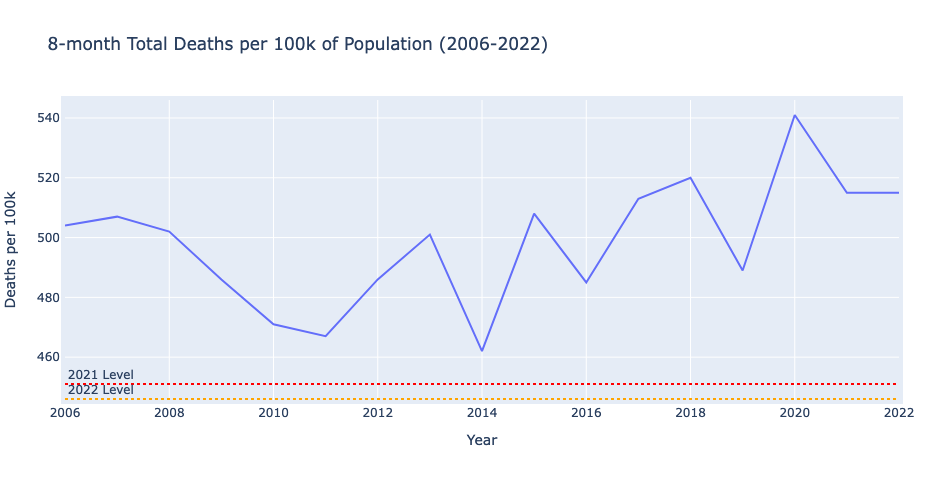

In [35]:
range_month_plot_title = str(analysis_end_month.value) + '-month Total Deaths per 100k of Population (2006-2022)'
fig_range_month_deaths_per_100k_17_yrs = df_range_months_deaths_per_100k.plot.line(title=range_month_plot_title,
                                                x='year', 
                                                y='deaths_per_100k')


fig_range_month_deaths_per_100k_17_yrs.add_hline(y=446, line_color="orange", line_dash="dot", annotation_text="2022 Level", annotation_position="top left")
fig_range_month_deaths_per_100k_17_yrs.add_hline(y=451, line_color="red", line_dash="dot", annotation_text="2021 Level", annotation_position="top left")

fig_range_month_deaths_per_100k_17_yrs.update_yaxes(title_text="Deaths per 100k")
fig_range_month_deaths_per_100k_17_yrs.update_xaxes(title_text="Year")

fig_range_month_deaths_per_100k_17_yrs.update_layout(
    height=500,
    margin=dict(
        l=50,
        r=50,
        b=100,
        t=100,
        pad=4
    )
)

fig_range_month_deaths_per_100k_17_yrs.show()

We can present this in a bar chart, which might be more useful.

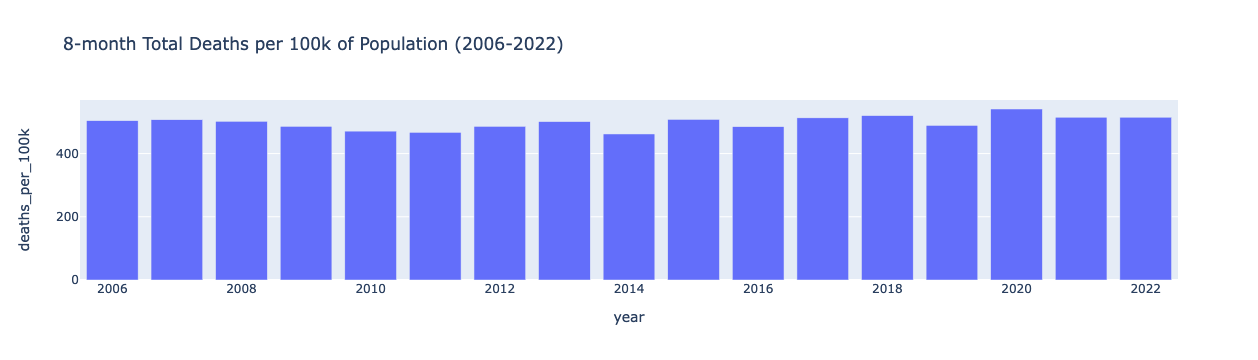

In [36]:
range_month_plot_title = str(analysis_end_month.value) + '-month Total Deaths per 100k of Population (2006-2022)'
fig_range_month_deaths_per_100k_17_yrs = df_range_months_deaths_per_100k.plot.bar(title=range_month_plot_title,
                                                x='year', 
                                                y='deaths_per_100k')
fig_range_month_deaths_per_100k_17_yrs.show()

We can compute the average (mean) annual deaths per 100k of the population for 2006-2019 and calculate the difference in 2020 and 2021 figures.

In [37]:
df_deaths_2006_to_2019 = df_twelve_month_deaths_per_100k[df_twelve_month_deaths_per_100k['year'] <= 2019] 

mean_deaths_2006_to_2019 = int(df_deaths_2006_to_2019[['deaths_per_100k']].mean(axis=0)[0])

debug_this(debug_enabled, 'The mean deaths for 12 months, per 100k of population between 2006 and 2019 is: ' + str(mean_deaths_2006_to_2019))

The mean deaths for 12 months, per 100k of population between 2006 and 2019 is: 822


In [38]:
df_deaths_2015_to_2019 = df_twelve_month_deaths_per_100k[(df_twelve_month_deaths_per_100k['year']<=2019) & (df_twelve_month_deaths_per_100k['year']>=2015)]

mean_deaths_2015_to_2019 = int(df_deaths_2015_to_2019[['deaths_per_100k']].mean(axis=0)[0])

debug_this(debug_enabled, 'The mean deaths for 12 months, per 100k of population for the five-year period 2015 and 2019 is: ' + str(mean_deaths_2015_to_2019))

The mean deaths for 12 months, per 100k of population for the five-year period 2015 and 2019 is: 840


In [39]:
df_deaths_per_100k_2015_to_2022 = df_twelve_month_deaths_per_100k[
    (df_twelve_month_deaths_per_100k['year'] == 2015) | 
    (df_twelve_month_deaths_per_100k['year'] == 2016) | 
    (df_twelve_month_deaths_per_100k['year'] == 2017) | 
    (df_twelve_month_deaths_per_100k['year'] == 2018) | 
    (df_twelve_month_deaths_per_100k['year'] == 2019) | 
    (df_twelve_month_deaths_per_100k['year'] == 2020) | 
    (df_twelve_month_deaths_per_100k['year'] == 2021) | 
    (df_twelve_month_deaths_per_100k['year'] == 2022)
].copy()

df_deaths_per_100k_2015_to_2022['14yr_avg'] = mean_deaths_2006_to_2019

df_deaths_per_100k_2015_to_2022['percentage_above_prior_14_year_average'] = \
((df_deaths_per_100k_2015_to_2022['deaths_per_100k'] - mean_deaths_2006_to_2019) / mean_deaths_2006_to_2019)*100

debug_this(debug_enabled, df_deaths_per_100k_2015_to_2022)

    year  deaths_per_100k  14yr_avg  percentage_above_prior_14_year_average
9   2015              839       822                                2.068127
10  2016              828       822                                0.729927
11  2017              857       822                                4.257908
12  2018              846       822                                2.919708
13  2019              832       822                                1.216545
14  2020              929       822                               13.017032
15  2021              917       822                               11.557178


We can see that there is a huge jump into double-digit percentage increase above the mean in 2020 with similar figures in 2021.

2022 is negative as expected as we only have five months worth of data.

Now we can adjust per population by calcuating deaths per 100k.

In [40]:
#TODO - Rewrite the below code in a generic way.
df_mye_2006_to_2022_transposed = df_mye_2006_to_2022.set_index('year').transpose()

df_monthly_deaths_typed['2006_'] = df_monthly_deaths_typed['2006'] * 100000 / df_mye_2006_to_2022_transposed[2006][0]
df_monthly_deaths_typed['2007_'] = df_monthly_deaths_typed['2007'] * 100000 / df_mye_2006_to_2022_transposed[2007][0]
df_monthly_deaths_typed['2008_'] = df_monthly_deaths_typed['2008'] * 100000 / df_mye_2006_to_2022_transposed[2008][0]
df_monthly_deaths_typed['2009_'] = df_monthly_deaths_typed['2009'] * 100000 / df_mye_2006_to_2022_transposed[2009][0]
df_monthly_deaths_typed['2010_'] = df_monthly_deaths_typed['2010'] * 100000 / df_mye_2006_to_2022_transposed[2010][0]
df_monthly_deaths_typed['2011_'] = df_monthly_deaths_typed['2011'] * 100000 / df_mye_2006_to_2022_transposed[2011][0]
df_monthly_deaths_typed['2012_'] = df_monthly_deaths_typed['2012'] * 100000 / df_mye_2006_to_2022_transposed[2012][0]
df_monthly_deaths_typed['2013_'] = df_monthly_deaths_typed['2013'] * 100000 / df_mye_2006_to_2022_transposed[2013][0]
df_monthly_deaths_typed['2014_'] = df_monthly_deaths_typed['2014'] * 100000 / df_mye_2006_to_2022_transposed[2014][0]
df_monthly_deaths_typed['2015_'] = df_monthly_deaths_typed['2015'] * 100000 / df_mye_2006_to_2022_transposed[2015][0]
df_monthly_deaths_typed['2016_'] = df_monthly_deaths_typed['2016'] * 100000 / df_mye_2006_to_2022_transposed[2016][0]
df_monthly_deaths_typed['2017_'] = df_monthly_deaths_typed['2017'] * 100000 / df_mye_2006_to_2022_transposed[2017][0]
df_monthly_deaths_typed['2018_'] = df_monthly_deaths_typed['2018'] * 100000 / df_mye_2006_to_2022_transposed[2018][0]
df_monthly_deaths_typed['2019_'] = df_monthly_deaths_typed['2019'] * 100000 / df_mye_2006_to_2022_transposed[2019][0]
df_monthly_deaths_typed['2020_'] = df_monthly_deaths_typed['2020'] * 100000 / df_mye_2006_to_2022_transposed[2020][0]
df_monthly_deaths_typed['2021_'] = df_monthly_deaths_typed['2021'] * 100000 / df_mye_2006_to_2022_transposed[2021][0]
df_monthly_deaths_typed['2022_'] = df_monthly_deaths_typed['2022'] * 100000 / df_mye_2006_to_2022_transposed[2022][0]

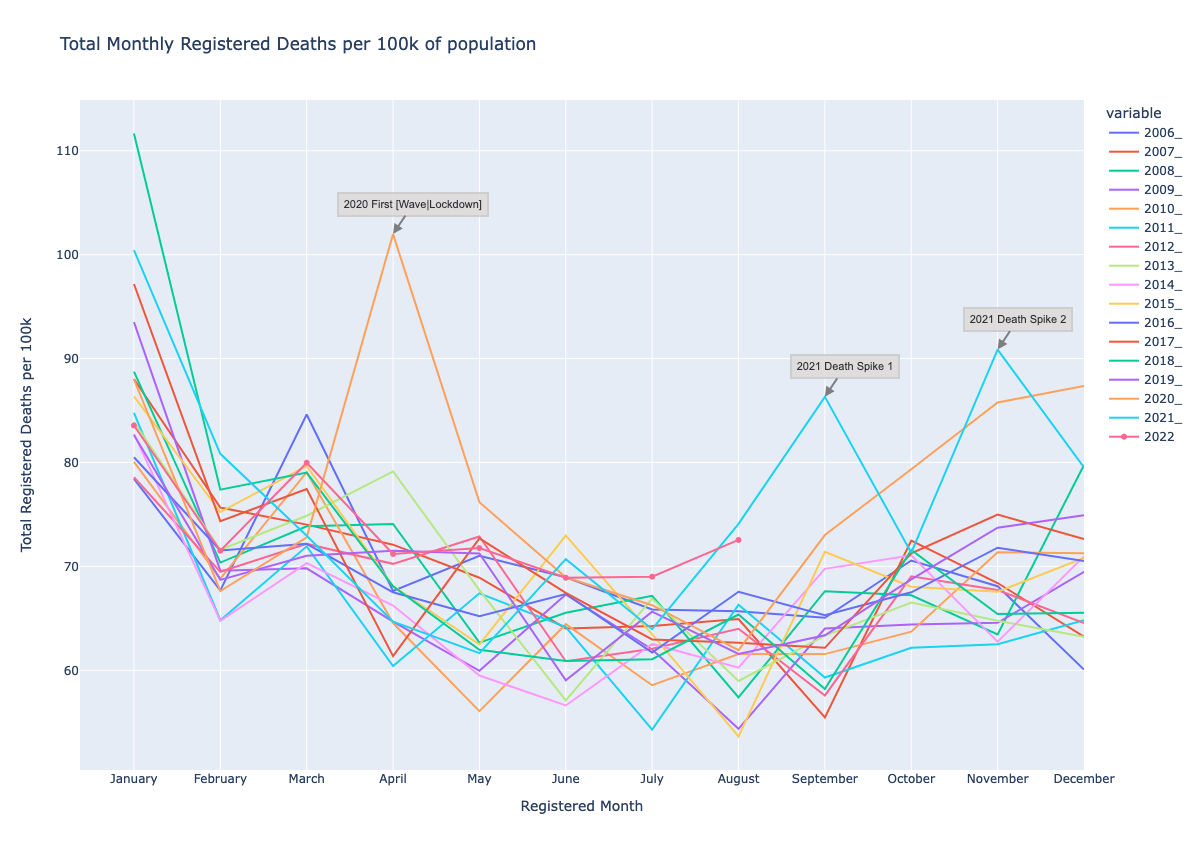

   Registration_Month  2006  2007  2008  2009  2010  2011  2012  2013  2014  \
0             January  1367  1551  1579  1677  1445  1538  1433  1535  1523   
1            February  1180  1333  1252  1248  1242  1176  1267  1310  1192   
2               March  1475  1304  1314  1252  1427  1305  1316  1370  1294   
3               April  1179  1270  1318  1160  1165  1096  1281  1448  1219   
4                 May  1238  1214  1115  1075  1012  1223  1329  1239  1095   
5                June  1202  1128  1166  1207  1163  1164  1110  1045  1042   
6                July  1148  1132  1195  1112  1057   985  1132  1224  1151   
7              August  1145  1144  1021   975  1111  1203  1167  1079  1109   
8           September  1134   977  1203  1148  1111  1076  1050  1159  1284   
9             October  1230  1277  1196  1155  1150  1128  1259  1217  1308   
10           November  1187  1205  1129  1158  1288  1134  1235  1185  1155   
11           December  1047  1114  1419  1246  1286 

In [41]:
fig_adj = px.line(df_monthly_deaths_typed, 
              x='Registration_Month', 
              y=['2006_', '2007_', '2008_', '2009_', '2010_', '2011_', '2012_', '2013_', '2014_', '2015_', '2016_', '2017_', '2018_', '2019_', '2020_', '2021_'], #, '2022_'
              title='Total Monthly Registered Deaths per 100k of population',
              height=850)

fig_adj.add_trace(
    go.Scatter(x=df_monthly_deaths_typed['Registration_Month'], y=df_monthly_deaths_typed['2022_'].loc[0:(analysis_end_month_for_deaths -1)], name="2022"),
    secondary_y=False,
)

fig_adj.add_annotation(
        x='April',
        y=101.9784,
        xref="x",
        yref="y",
        text="2020 First [Wave|Lockdown]",
        showarrow=True,
        font=dict(
            family="Arial",
            size=11,
            color="#020202"
            ),
        align="center",
        arrowhead=2,
        arrowsize=1,
        arrowwidth=2,
        arrowcolor="#636363",
        ax=20,
        ay=-30,
        bordercolor="#c7c7c7",
        borderwidth=2,
        borderpad=4,
        bgcolor="#ddd9d8 ",
        opacity=0.8
        )

fig_adj.add_annotation(
        x='September',
        y=86.31951,
        xref="x",
        yref="y",
        text="2021 Death Spike 1",
        showarrow=True,
        font=dict(
            family="Arial",
            size=11,
            color="#020202"
            ),
        align="center",
        arrowhead=2,
        arrowsize=1,
        arrowwidth=2,
        arrowcolor="#636363",
        ax=20,
        ay=-30,
        bordercolor="#c7c7c7",
        borderwidth=2,
        borderpad=4,
        bgcolor="#ddd9d8 ",
        opacity=0.8
        )

fig_adj.add_annotation(
        x='November',
        y=90.865,
        xref="x",
        yref="y",
        text="2021 Death Spike 2",
        showarrow=True,
        font=dict(
            family="Arial",
            size=11,
            color="#020202"
            ),
        align="center",
        arrowhead=2,
        arrowsize=1,
        arrowwidth=2,
        arrowcolor="#636363",
        ax=20,
        ay=-30,
        bordercolor="#c7c7c7",
        borderwidth=2,
        borderpad=4,
        bgcolor="#ddd9d8 ",
        opacity=0.8
        )

# Set x-axis title
fig_adj.update_xaxes(title_text="Registered Month")

# Set y-axes titles
fig_adj.update_yaxes(title_text="Total Registered Deaths per 100k", secondary_y=False)

fig_adj.show()

if debug_enabled:
    print(df_monthly_deaths_typed)

Now we have adjusted the monthly death figures to compare like-for-like over the preceeding 17 years.  

We have plotted total deaths per month per 100k of the population.

Significant jumps in death in August, September and November of 2021 even above and beyond the "pandemic" year of 2020.  October of 2021 also had slightly elevated total deaths.

The next question we should ask is what was causing the increased deaths at these times?

# Vaccine Rollout
Can we identify the dates of distribution of vaccines across Northern Ireland?

We can manuall create a dataset from the cumulative dose distribution figures on this dashboard: https://covid-19.hscni.net/ni-covid-19-vaccinations-dashboard/

In [42]:
df_vaccine_rollout = pd.read_excel('data/inbound/derived/hscni/vaccine/NorthernIrelandCovidVaccine.xlsx', 
                                  sheet_name='totals', 
                                  skiprows=0, 
                                  nrows=20,
                                  usecols='A:H')

debug_this(debug_enabled, df_vaccine_rollout)

    Year      Month  Primary Dose 1  Primary Dose 2  Primary Dose 3  \
0   2020   December           39319             884               0   
1   2021    January          233323           21478               0   
2   2021   February          553318           31415               0   
3   2021      March          799300          176582               0   
4   2021      April          977760          462533               0   
5   2021        May         1090452          709735               0   
6   2021       June         1186179          908006               0   
7   2021       July         1246331         1075288               0   
8   2021     August         1302822         1189000               0   
9   2021  September         1324648         1225432             348   
10  2021    October         1339096         1259062           10379   
11  2021   November         1378888         1280548           18195   
12  2021   December         1403380         1299557           20116   
13  20

Let's take 2021 only and the Total Cumulative Vaccine Doses figure for each month.

In [43]:
df_2021_total_cumulative_vaccines_per_month = df_vaccine_rollout[df_vaccine_rollout['Year'] == 2021][['Month', 'Primary Dose 1', 'Primary Dose 2', 'Primary Dose 3', '1st Booster Dose', 'Spring 2022 Booster Dose',  'Total_Cumulative_Vaccine_Doses']] #  df_deaths_2006_to_2019 = df_twelve_month_deaths_per_100k[df_twelve_month_deaths_per_100k['year'] <= 2019] 

In [44]:
df_2021_monthly_deaths = df_monthly_deaths_typed[['Registration_Month', '2021']]

debug_this(debug_enabled, df_2021_monthly_deaths)

   Registration_Month  2021
0             January  1922
1            February  1547
2               March  1396
3               April  1238
4                 May  1180
5                June  1353
6                July  1224
7              August  1418
8           September  1652
9             October  1365
10           November  1739
11           December  1522


Let's join the vaccine and deaths dataframes together on month.

In [45]:
df_2021_vaccines_and_death = df_2021_total_cumulative_vaccines_per_month.merge(df_2021_monthly_deaths, how='inner', left_on='Month', right_on='Registration_Month') 

Let's plot both doses and deaths on the same line chart.

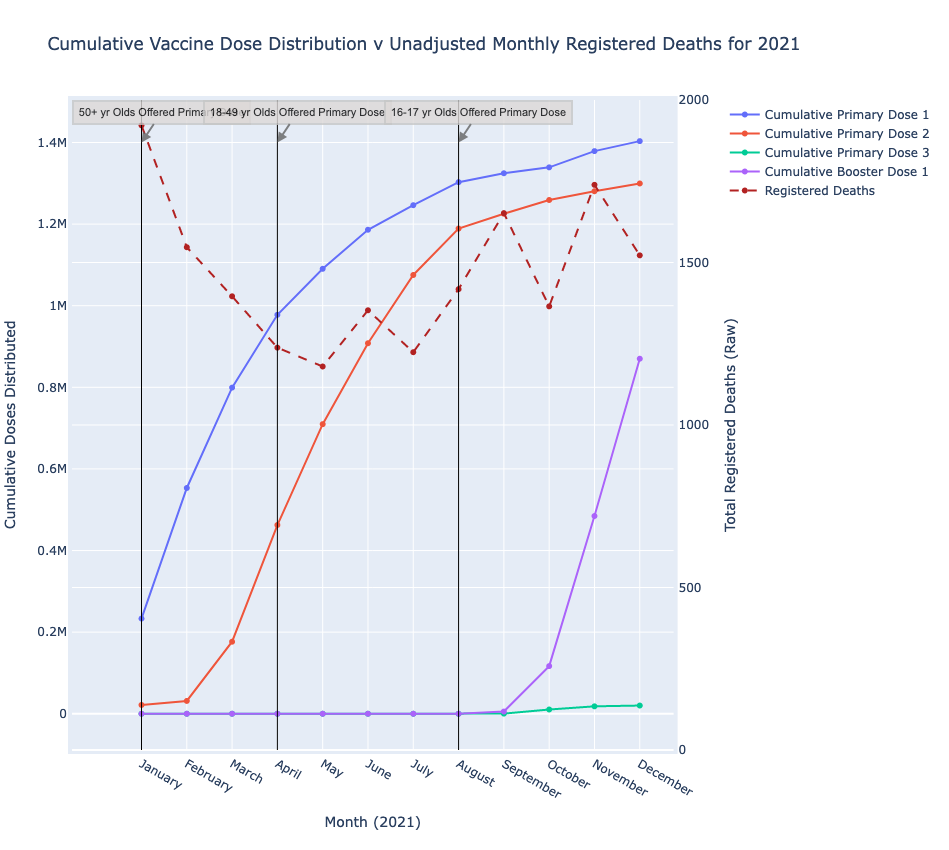

In [46]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import datetime

# Create figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Add traces
# fig.add_trace(
#     go.Scatter(x=df_2021_vaccines_and_death['Month'], y=df_2021_vaccines_and_death['Total_Cumulative_Vaccine_Doses'], name="Total Cumulative Doses"),
#     secondary_y=False,
# )

fig.add_trace(
    go.Scatter(x=df_2021_vaccines_and_death['Month'], y=df_2021_vaccines_and_death['Primary Dose 1'], name="Cumulative Primary Dose 1"),
    secondary_y=False,
)

fig.add_trace(
    go.Scatter(x=df_2021_vaccines_and_death['Month'], y=df_2021_vaccines_and_death['Primary Dose 2'], name="Cumulative Primary Dose 2"),
    secondary_y=False,
)

fig.add_trace(
    go.Scatter(x=df_2021_vaccines_and_death['Month'], y=df_2021_vaccines_and_death['Primary Dose 3'], name="Cumulative Primary Dose 3"),
    secondary_y=False,
)

fig.add_trace(
    go.Scatter(x=df_2021_vaccines_and_death['Month'], y=df_2021_vaccines_and_death['1st Booster Dose'], name="Cumulative Booster Dose 1"),
    secondary_y=False, 
)


fig.add_trace(
    go.Scatter(x=df_2021_vaccines_and_death['Registration_Month'], y=df_2021_vaccines_and_death['2021'], 
               name="Registered Deaths", line=dict(color='firebrick', width=2,dash='dash')),
    secondary_y=True,
)


# Interestingly enough there is a bug in plotly that doesn't support annotations on vertical lines upon charts with categorical data along the x-axis.
#fig.add_vline(x=datetime.datetime.strptime("January", "%B").timestamp() * 1000, annotation_text="test", line_width=1, line_color='black' )

fig.add_vline(x='January', line_width=1, line_color='black')
fig.add_annotation(
        x='January',
        y=1400000,
        xref="x",
        yref="y",
        text="50+ yr Olds Offered Primary Dose",
        showarrow=True,
        font=dict(
            family="Arial",
            size=11,
            color="#020202"
            ),
        align="center",
        arrowhead=2,
        arrowsize=1,
        arrowwidth=2,
        arrowcolor="#636363",
        ax=20,
        ay=-30,
        bordercolor="#c7c7c7",
        borderwidth=2,
        borderpad=4,
        bgcolor="#ddd9d8 ",
        opacity=0.8
        )

fig.add_vline(x='April', line_width=1, line_color='black')
fig.add_annotation(
        x='April',
        y=1400000,
        xref="x",
        yref="y",
        text="18-49 yr Olds Offered Primary Dose",
        showarrow=True,
        font=dict(
            family="Arial",
            size=11,
            color="#020202"
            ),
        align="center",
        arrowhead=2,
        arrowsize=1,
        arrowwidth=2,
        arrowcolor="#636363",
        ax=20,
        ay=-30,
        bordercolor="#c7c7c7",
        borderwidth=2,
        borderpad=4,
        bgcolor="#ddd9d8 ",
        opacity=0.8
        )


fig.add_vline(x='August', line_width=1, line_color='black')
fig.add_annotation(
        x='August',
        y=1400000,
        xref="x",
        yref="y",
        text="16-17 yr Olds Offered Primary Dose",
        showarrow=True,
        font=dict(
            family="Arial",
            size=11,
            color="#020202"
            ),
        align="center",
        arrowhead=2,
        arrowsize=1,
        arrowwidth=2,
        arrowcolor="#636363",
        ax=20,
        ay=-30,
        bordercolor="#c7c7c7",
        borderwidth=2,
        borderpad=4,
        bgcolor="#ddd9d8 ",
        opacity=0.8
        )

fig.update_layout(
    height=850,
    margin=dict(
        l=50,
        r=50,
        b=100,
        t=100,
        pad=4
    )
)

# Add figure title
fig.update_layout(
    title_text="Cumulative Vaccine Dose Distribution v Unadjusted Monthly Registered Deaths for 2021"
)

# Set x-axis title
fig.update_xaxes(title_text="Month (2021)")

# Set y-axes titles
fig.update_yaxes(title_text="Cumulative Doses Distributed", secondary_y=False)
fig.update_yaxes(title_text="Total Registered Deaths (Raw)", secondary_y=True) #<b>secondary</b>

fig.update_yaxes(range=[0, 2000], secondary_y=True)
#fig.update_xaxes(range=[3, 9])

fig.show()

# https://plotly.com/python/line-charts/

###########
# # Chat-GPT alternative code:
# import plotly.graph_objs as go
# from plotly.subplots import make_subplots

# # Create figure with secondary y-axis
# fig = make_subplots(specs=[[{"secondary_y": True}]])

# # Add traces
# vaccine_doses_traces = [
#     ('Total Cumulative Doses', 'Total_Cumulative_Vaccine_Doses', False),
#     ('Cumulative Primary Dose 1', 'Primary Dose 1', False),
#     ('Cumulative Primary Dose 2', 'Primary Dose 2', False),
#     ('Cumulative Primary Dose 3', 'Primary Dose 3', False),
#     ('Cumulative Booster Dose 1', '1st Booster Dose', False),
# ]

# for trace_name, y_column, is_secondary in vaccine_doses_traces:
#     fig.add_trace(
#         go.Scatter(x=df_2021_vaccines_and_death['Month'], y=df_2021_vaccines_and_death[y_column], name=trace_name),
#         secondary_y=is_secondary
#     )

# fig.add_trace(
#     go.Scatter(
#         x=df_2021_vaccines_and_death['Registration_Month'], 
#         y=df_2021_vaccines_and_death['2021'], 
#         name="Registered Deaths", 
#         line=dict(color='firebrick', width=2, dash='dash')
#     ),
#     secondary_y=True,
# )

# vline_annotations = [
#     ('January', '50+ yr Olds Offered Primary Dose'),
#     ('April', '18-49 yr Olds Offered Primary Dose'),
#     ('August', '16-17 yr Olds Offered Primary Dose'),
# ]

# for vline_x, annotation_text in vline_annotations:
#     fig.add_vline(x=vline_x, line_width=1, line_color='black')
#     fig.add_annotation(
#         x=vline_x,
#         y=1400000,
#         xref="x",
#         yref="y",
#         text=annotation_text,
#         showarrow=True,
#         font=dict(
#             family="Arial",
#             size=11,
#             color="#020202"
#         ),
#         align="center",
#         arrowhead=2,
#         arrowsize=1,
#         arrowwidth=2,
#         arrowcolor="#636363",
#         ax=20,
#         ay=-30,
#         bordercolor="#c7c7c7",
#         borderwidth=2,
#         borderpad=4,
#         bgcolor="#ddd9d8 ",
#         opacity=0.8
#     )

# # Update layout
# fig.update_layout(
#     height=850,
#     margin=dict(l=50, r=50, b=100, t=100, pad=4),
#     title_text="Cumulative Vaccine Dose Distribution v Unadjusted Monthly Registered Deaths for 2021",
#     xaxis_title="Month (2021)",
#     yaxis=dict(title="Cumulative Doses Distributed"),
#     yaxis2=dict(title="Total Registered Deaths (Raw)", range=[0, 2000], overlaying="y", side="right")
# )

# fig.show()


So it looks like we have four notable rises in June, August, September and December correlated with increased rollout of the vaccines.

Let's plot 2022 figures (for the months for which we have data).

Referring to the information published here https://covid-19.hscni.net/ni-covid-19-vaccinations-dashboard/ the vaccine programme was distributed as a Primary Course and a one or more Booster Doses.

A Primary Course was either 2 or 3 doses).
A Booster is a single dose.

Regarding age group and vaccine distribution we can surmise:

* Care home residents and front-line health workers did not receive their first primary dose before 01 December 2020.
* 50+ Year Olds did not receive their first primary dose before 01 January 2021
* Vulnerable 18-49 Year Olds did not receive their Pfirst primary dose before 01 January 2021
* 18-49 Year Olds did not receive their first primary dose before 01 April 2021
* Pregnant women did not receive their first primary dose before 01 April 2021
* 16-17 Year Olds did not receive their first primary dose before 01 August 2021
* Vulnerable 12-15 Year Olds did not receive their first primary dose before 01 August 2021
* 12-15 Year Olds did not receive their first primary dose before 01 September 2021
* Vulnerable 12+ Year Olds did not receive their third primary dose before 01 September 2021
* Vulnerable 5-11 Year Olds did not receive their first primary dose before 01 December 2021
* 5-11 Year Olds did not receive their first primary dose before 01 February 2022

In [47]:
df_2022_total_cumulative_vaccines_per_month = df_vaccine_rollout[df_vaccine_rollout['Year'] == 2022][['Month', 'Primary Dose 1', 'Primary Dose 2', 'Primary Dose 3', '1st Booster Dose', 'Spring 2022 Booster Dose',  'Total_Cumulative_Vaccine_Doses']]
debug_this(debug_enabled, df_2022_total_cumulative_vaccines_per_month)

       Month  Primary Dose 1  Primary Dose 2  Primary Dose 3  \
13   January         1412624         1312851           20586   
14  February         1417042         1322727           20779   
15     March         1420712         1330082           20876   
16     April         1423900         1337458           20947   
17       May         1425756         1343504           21036   
18      June         1426274         1343899           21116   
19      July         1427323         1349799           21156   

    1st Booster Dose  Spring 2022 Booster Dose  Total_Cumulative_Vaccine_Doses  
13            946790                         0                         3692851  
14            968830                         0                         3729378  
15            981394                       497                         3753561  
16            992974                     41273                         3816552  
17           1004638                    124000                         3918934  
1

In [48]:
df_2022_monthly_deaths = df_monthly_deaths_typed[['Registration_Month', '2022']][0:(analysis_end_month+1)]
debug_this(debug_enabled, df_2022_monthly_deaths)

  Registration_Month  2022
0            January  1608
1           February  1376
2              March  1539
3              April  1370
4                May  1381
5               June  1326
6               July  1328
7             August  1396
8          September     0


In [49]:
df_2022_vaccines_and_death = df_2022_total_cumulative_vaccines_per_month.merge(df_2022_monthly_deaths, how='inner', left_on='Month', right_on='Registration_Month') 
debug_this(debug_enabled, df_2022_vaccines_and_death)

      Month  Primary Dose 1  Primary Dose 2  Primary Dose 3  1st Booster Dose  \
0   January         1412624         1312851           20586            946790   
1  February         1417042         1322727           20779            968830   
2     March         1420712         1330082           20876            981394   
3     April         1423900         1337458           20947            992974   
4       May         1425756         1343504           21036           1004638   
5      June         1426274         1343899           21116           1005533   
6      July         1427323         1349799           21156           1012717   

   Spring 2022 Booster Dose  Total_Cumulative_Vaccine_Doses  \
0                         0                         3692851   
1                         0                         3729378   
2                       497                         3753561   
3                     41273                         3816552   
4                    124000         

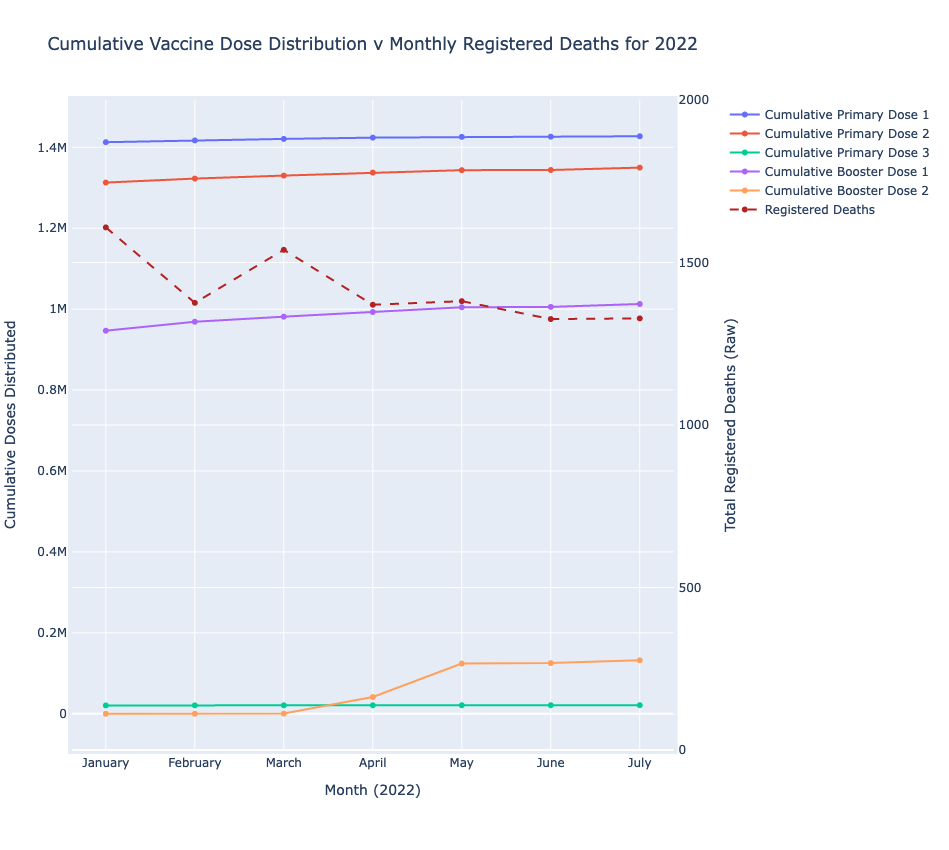

In [50]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Create fig_2022ure with secondary y-axis
fig_2022 = make_subplots(specs=[[{"secondary_y": True}]])


# fig_2022.add_trace(
#     go.Scatter(x=df_2022_vaccines_and_death['Month'], y=df_2022_vaccines_and_death['Total_Cumulative_Vaccine_Doses'], name="Total Cumulative Doses"),
#     secondary_y=False,
# )

fig_2022.add_trace(
    go.Scatter(x=df_2022_vaccines_and_death['Month'], y=df_2022_vaccines_and_death['Primary Dose 1'], name="Cumulative Primary Dose 1"),
    secondary_y=False,
)

fig_2022.add_trace(
    go.Scatter(x=df_2022_vaccines_and_death['Month'], y=df_2022_vaccines_and_death['Primary Dose 2'], name="Cumulative Primary Dose 2"),
    secondary_y=False,
)

fig_2022.add_trace(
    go.Scatter(x=df_2022_vaccines_and_death['Month'], y=df_2022_vaccines_and_death['Primary Dose 3'], name="Cumulative Primary Dose 3"),
    secondary_y=False,
)

fig_2022.add_trace(
    go.Scatter(x=df_2022_vaccines_and_death['Month'], y=df_2022_vaccines_and_death['1st Booster Dose'], name="Cumulative Booster Dose 1"),
    secondary_y=False,
)


fig_2022.add_trace(
    go.Scatter(x=df_2022_vaccines_and_death['Month'], y=df_2022_vaccines_and_death['Spring 2022 Booster Dose'], name="Cumulative Booster Dose 2"),
    secondary_y=False,
)


fig_2022.add_trace(
    go.Scatter(x=df_2022_vaccines_and_death['Registration_Month'], y=df_2022_vaccines_and_death['2022'], 
               name="Registered Deaths", line=dict(color='firebrick', width=2,dash='dash')),
    secondary_y=True,
)

# Add fig_2022ure title
fig_2022.update_layout(
    title_text="Cumulative Vaccine Dose Distribution v Monthly Registered Deaths for 2022"
)

# Set x-axis title
fig_2022.update_xaxes(title_text="Month (2022)")

# Set y-axes titles
fig_2022.update_yaxes(title_text="Cumulative Doses Distributed", secondary_y=False)
fig_2022.update_yaxes(title_text="Total Registered Deaths (Raw)", secondary_y=True) #<b>secondary</b>

fig_2022.update_yaxes(range=[0, 2000], secondary_y=True)

fig_2022.update_layout(
    height=850,
    margin=dict(
        l=50,
        r=50,
        b=100,
        t=100,
        pad=4
    )
)

fig_2022.show()

# https://plotly.com/python/line-charts/

If we're going to dig in and determine what happened the people that died in 2021 during the Autumnal period we need the cause of death data for Northern Ireland for that year.

This information seems to be published by NISRA and here is the link for 2020 which was published a whole two years after the fact: - https://www.nisra.gov.uk/publications/registrar-general-annual-report-2020-cause-death

We don't yet seem to have this data for 2021.  That said the document here https://www.nisra.gov.uk/publications/registrar-general-annual-report-2020-cause-death#:~:text=Cause%20of%20Death%202020%20Tables%0AExcel%20(569%20KB) has been downloaded and we can play with this to at least prepare our code if we need to.

A more up-to-date document appears to be this - https://www.nisra.gov.uk/statistics/registrar-general-quarterly-report/registrar-general-quarterly-tables